# Vorbereitung

In [1]:
%env KERAS_BACKEND=theano
%env THEANO_FLAGS=floatX=float32,device=cpu

env: KERAS_BACKEND=theano
env: THEANO_FLAGS=floatX=float32,device=cpu


In [2]:
%load_ext autoreload
%autoreload 1
%aimport bb_behavior
%aimport bb_behavior.plot
%aimport bb_behavior.tracking
%aimport bb_behavior.tracking.pipeline

import bb_behavior
import bb_behavior.plot
import bb_behavior.tracking
import bb_behavior.tracking.pipeline

import pandas as pd
import time
import datetime

Using Theano backend.


# Preprocessing

## Preprocessing step 1: convert the h264 to mp4

## Run

In [3]:
from bb_behavior.tracking.pipeline import get_default_pipeline
default_pipeline = None
default_pipeline = get_default_pipeline(localizer_threshold="0.50")

/Users/ronnyruhe/.local/lib/python3.7/site-packages/keras/backend/theano_backend.py:1032: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/Users/ronnyruhe/.local/lib/python3.7/site-packages/keras/backend/theano_backend.py:1032: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/Users/ronnyruhe/.local/lib/python3.7/site-packages/keras/backend/theano_backend.py:1032: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


In [4]:
from tqdm import tqdm_notebook # progress bar

import math
import numpy as np
from bb_tracking.data.constants import DETKEY
#from bb_tracking.tracking import score_id_sim_v
from bb_tracking.tracking import distance_orientations_v, distance_positions_v

from bb_behavior.tracking.pipeline import detect_markers_in_video
from bb_behavior.tracking.pipeline import track_detections_dataframe
from bb_behavior.tracking.pipeline import display_tracking_results

In [5]:
config = dict(tag_pixel_diameter=50,
              n_frames=None,
              confidence_filter_detections=0.08,
              confidence_filter_tracks=0.20,
              coordinate_scale=1.0,
              start_time=None,
              fps=10.0,
              cam_id=0,
              left_leaving_area = 0.30, # Prozente vom Bildschirmrand, zB. bei 1000px und 0.15 -> 0-150px
              right_leaving_area = 0.30,
              px_x_resolution_vid = 1944)


In [6]:
import time
import os

def filename_to_datestring(filname):
    """
    filename can be path
    """
    return os.path.split(filname)[-1].split('.')[0].split('_')[1]


def string_to_timestamp(datestring):
    """ 
    params
        string: format 2018-08-19-01-08-13
    output
        unix timestamp (float)
    """
    
    return time.mktime(time.strptime(datestring, "%Y-%m-%d-%H-%M-%S"))

def timestamp_to_string(timestamp):
    return time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime(timestamp))

In [7]:
# Einen Iterable speichern, der alle Videos in einem Iterable zur Verfügung stellt
# Diesen Iterable können wir dann in der nächsten Zelle mit tqdm schön durchlaufen
# nicht sehr performant --> O(n)
import os
base_directory = "../videos/"
paths = [i for i in os.listdir(base_directory) if i.endswith(".h264")]
for i in range(len(paths)):
    paths[i] = base_directory + paths[i]

In [8]:
# Hier passiert das eigentliche Tracken und speichern der Ergebnisse:
num_processed_videos = 0
video_data = dict()
frame_info = None
detections = None
videos_w_no_detection = ""


for path in tqdm_notebook(paths):
    start_time = config["start_time"]
    cam_id = config["cam_id"]
    try:
        num_processed_videos += 1

        frame_info, detections = detect_markers_in_video(path,
                                                      decoder_pipeline=default_pipeline,#pipeline=pipelines(),
                                                     tag_pixel_diameter=config["tag_pixel_diameter"],
                                                      n_frames=config["n_frames"],
                                                      fps=config["fps"],
                                                     progress="tqdm_notebook"
                                            )
        tracks = track_detections_dataframe(detections,
                                            tracker="tracker.det_score_fun.frag_score_fun.dill",
                                            confidence_filter_detections=config["confidence_filter_detections"],
                                           confidence_filter_tracks=config["confidence_filter_tracks"],
                                            coordinate_scale=config["coordinate_scale"]
                                           )
        date_string = filename_to_datestring(path)
        tracks['video'] = date_string
        video_data[path] = (frame_info, detections, tracks)
    except ValueError as err: #tritt auf, wenn Video leer ist. In diesem Fall: überspringe video
        try:
            videos_w_no_detection = videos_w_no_detection + path + "\n"
            paths.remove(path)
            # wir arbeiten später nochmal mit paths, daher müssen das leere löschen, weil sonst
            # in video_data kein zugehöriger Value zu Key = file zu finden ist.
        except KeyError as err:
            continue
    except Exception as err:
        print(err)
        raise
    # only first vid: break

/Users/ronnyruhe/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/ronnyruhe/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LinearSVC from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/ronnyruhe/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator Pipeline from version 0.20.0 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/ronnyruhe/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.0 when using version 0.20.1. This might le

In [9]:
#gebe Videos aus, in denen keine Bienen gefunden wurden
if videos_w_no_detection:
    print("In the following file(s) were no bees detected:")
    print(videos_w_no_detection)

Found 77 detections belonging to 2 unique tracks and 2 individuals.


/Users/ronnyruhe/.local/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


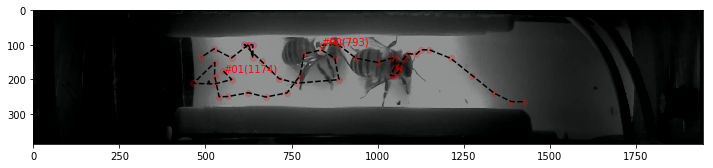

Detection/track statistics:


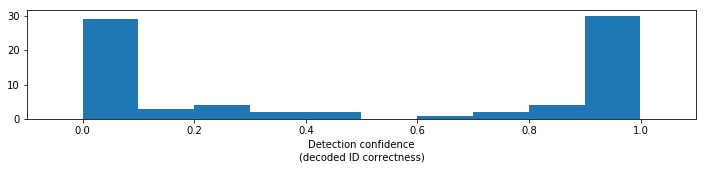

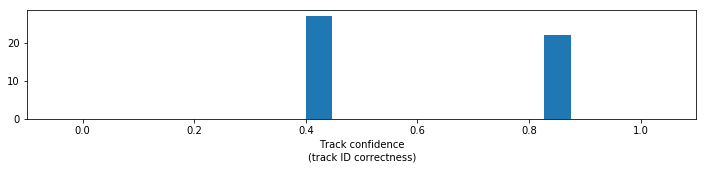

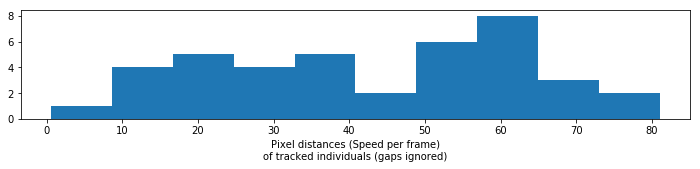

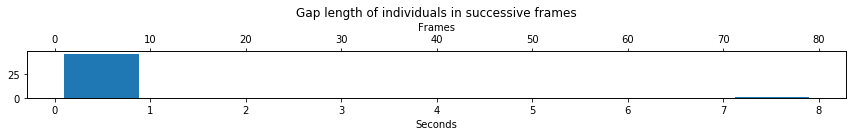

Individual statistics:


ModuleNotFoundError: No module named 'cairocffi'

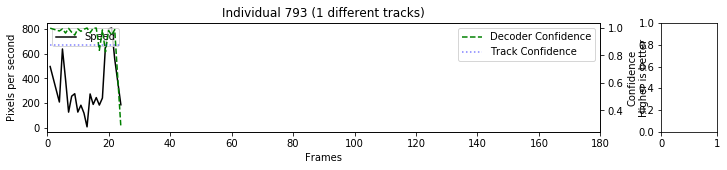

In [10]:
#video_data["file"][0] --> frame-info, [1] --> detections, [2] --> tracks
for path in paths:
    display_tracking_results(path, video_data[path][0], video_data[path][1], video_data[path][2])

# Modify data to default for all Algorithms / Save detection to .csv

In [11]:
tracks = [video_data[paths[x]][2] for x in range(len(paths))]
tracks = pd.concat(tracks,ignore_index=True)
tracks = tracks.drop(columns=["localizerSaliency", "beeID", "camID", "frameIdx"])

In [12]:
with open("tracks.csv", "w") as f:
    tracks.to_csv(f)

In [13]:
tracks

,id,xpos,ypos,zrotation,timestamp,confidence,track_id,track_confidence,bee_id,video
0,f17745262213455944850d0c0,837.337231,100.917238,-0.353094,0.0,0.761272,0.0,0.874410,793.0,2018-08-19-16-52-52
1,f14267357616683677421d0c0,887.020819,101.098423,-0.253130,0.1,0.997726,0.0,0.874410,793.0,2018-08-19-16-52-52
2,f17519573800468124328d0c0,936.745340,138.785250,-0.094255,0.4,0.977464,0.0,0.874410,793.0,2018-08-19-16-52-52
3,f16898132806785162608d0c0,999.533021,151.101185,-0.074583,0.5,0.992433,0.0,0.874410,793.0,2018-08-19-16-52-52
4,f11305406973771542514d0c0,1037.264179,139.694832,0.111126,0.6,0.962261,0.0,0.874410,793.0,2018-08-19-16-52-52
5,f15385388925154222279d1c0,1049.828773,139.267897,0.100314,0.7,0.996251,0.0,0.874410,793.0,2018-08-19-16-52-52
6,f11546775848204856048d0c0,1049.892881,164.813738,0.445942,0.8,0.968032,0.0,0.874410,793.0,2018-08-19-16-52-52
7,f12901894171407934499d1c0,1037.219709,189.300098,0.254706,0.9,0.947535,0.0,0.874410,793.0,2018-08-19-16-52-52
8,f16849697806518099865d0c0,1049.828238,189.478880,0.244945,1.0,0.992318,0.0,0.874410,793.0,2018-08-19-16-52-52
9,f11578931544662934728d0c0,1062.589064,176.510939,0.176081,1.1,0.975000,0.0,0.874410,793.0,2018-08-19-16-52-52


In [14]:
# ERGEBNIS-DICT, kann mit pd.DataFrame(data=bee_moves) in DataFrame gewandelt werden
bee_moves = {"bee_id":[], "time_in":[], "os_in":[], "time_out":[], "os_out":[], "in_direction":[], "out_direction":[]}

# Algorithmus 1: Baseline

In [190]:
""" Vorgehen:
Für jedes Video
- Prüfe, wo sich die Biene beim ersten erkannten Erscheinen aufhält
    - Ordne die Position in left, right oder middle ein
- Prüfe, wo sich die Biene beim letzten erkannten Erscheinen aufhält
    - Ordne die Position in left, right oder middle ein
Daraus kann nun abgeleitet werden, wo die Biene reingekommen ist und wo sie rausgegangen ist
"""

def baseline_alg_classify_bee():
    video_groups = tracks.groupby(["video"])
    for group_name, df_group in video_groups:
        movement = dict()
        recording_begin = group_name

        # Finde start- und endposition
        for row in df_group.itertuples():
            bee_id = row[9]
            xpos = row[2]
            ypos = row[3]
            timestamp = row[5]

            if bee_id in movement.keys():
                if not movement[bee_id]: #hier wird value betrachtet
                    # Aufbau movement[bee_id] = 
                    # [(xpos_anfang, ypos_anfang), (xpos_ende, ypos_ende), time_in bzw. time_out, os_in, os_out]
                    movement[bee_id] = [(xpos, ypos), (xpos, ypos), recording_begin, timestamp, timestamp]
                else: #spätere detection in Video -> aktualisiere
                    movement[bee_id][1] = (xpos, ypos)
                    movement[bee_id][-1] = timestamp
            else:
                movement[bee_id] = [(xpos, ypos), (xpos, ypos), recording_begin, timestamp, timestamp]

        def is_left(xpos):
            return xpos <= config["left_leaving_area"]*config["px_x_resolution_vid"]
        def is_right(xpos):
            return xpos >= config["px_x_resolution_vid"] - config["right_leaving_area"]*config["px_x_resolution_vid"]

        # Setze labels, entferne andere Daten
        for bee_id in movement.keys():
            start_pos = movement[bee_id][0]
            end_pos = movement[bee_id][1]
            labels = dict()

            # Eintrittsseite festlegen
            if is_left(start_pos[0]):
                labels["in_direction"] = "left"
            elif is_right(start_pos[0]):
                labels["in_direction"] = "right"
            else:
                labels["in_direction"] = "middle"

            # Austrittsseite festlegen
            if is_left(end_pos[0]):
                labels["out_direction"] = "left"
            elif is_right(end_pos[0]):
                labels["out_direction"] = "right"
            else:
                labels["out_direction"] = "middle"

            bee_moves["bee_id"].append(bee_id)
            bee_moves["in_direction"].append(labels["in_direction"])
            bee_moves["out_direction"].append(labels["out_direction"])
            bee_moves["time_in"].append(movement[bee_id][2])
            bee_moves["time_out"].append(movement[bee_id][2])
            bee_moves["os_in"].append(movement[bee_id][3])
            bee_moves["os_out"].append(movement[bee_id][4])

In [127]:
# Ausgeben
baseline_alg_classify_bee()
bee_moves = pd.DataFrame(data=bee_moves)
bee_moves

TypeError: cannot concatenate object of type "<class 'float'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

# Vergleichsfunktion Algorithmus mit Labels

In [ ]:
# gelabelted Datensatz einlesen:
labeled_data = pd.read_csv("labels.csv")
labeled_data = labeled_data.filter(["bee_id", "video", "in_direction", "out_direction"])

# nur ein Video betrachten:
#labeled_data = labeled_data[labeled_data["video"] == "e00_2018-08-19-12-34-35.h264"].drop(columns=["video"])

# Vergleichen

for bee_id in results["bee_id"]:
    if results[bee_id] in labeled_data["bee_id"]:
        if results[bee_id]
    

# Compare-Algorithm

In [191]:
""" 
Precondition:
Fetch computed data and GroundTruthData from generated csv files and store in dictionaries.
"""

# read data from GroundTruthData.csv files
import csv
# use Dictionary to store data we want to compare
dicManually = {} # key - List
dicAutomated = {} # key - List

# fetching data from MaschineLearnedData.csv file 
with open("MaschineLearnedData.csv", "r") as testFile:
    """ fetch all data from csv file to store in dicAutomated for better search and use """
    reader = csv.DictReader(testFile)
    for row in reader:
        # store video in dicAutomated
        if not (row['video'] in dicAutomated):
            # add video to dic with his bees
            dicAutomated[row['video']] = [[row['bee_id'], row['in_direction'], row['out_direction'], row['timestamp_in'], row['timestamp_out']]]
        else:
            #add other bees to the video key
            dicAutomated[row['video']].append([row['bee_id'], row['in_direction'], row['out_direction'], row['timestamp_in'], row['timestamp_out']])

# fetching data from GroundTruthData.csv
with open("GroundTruthData.csv", "r") as testFile:
    """ fetch all data from csv file to store in diManually for better search and use """
    reader = csv.DictReader(testFile)
    for row in reader:
        # check row has an bee_id -> if nor go to next row
        if (row['bee_id'] != ""):
            # store video in dicManually 
            if not (row['video'] in dicManually):
                # add video to dic with his bees
                dicManually[row['video']] = [[row['bee_id'], row['in_direction'], row['out_direction'], row['timestamp_in'], row['timestamp_out']]]
            else:
                #add other bees to the video key
                dicManually[row['video']].append([row['bee_id'], row['in_direction'], row['out_direction'], row['timestamp_in'], row['timestamp_out']])
        else:
            continue
            

In [192]:
""" Compare input of MaschineLearnedData.csv with GroundTruthData.csv to get just compareable tracks """

# delete values which are not included in dicAutomated
for msData in list(dicManually):
    if not (msData in dicAutomated):
        dicManually.pop(msData)
        
# delete values which are noch included in dicManually
for msData in list(dicAutomated):
    if not (msData in dicManually):
        dicAutomated.pop(msData)

""" print video-match """ 
print(len(dicManually))
print(len(dicAutomated))


In [178]:
# method to print result to csv
def insertCSV(video, bee, mboolean):
    attache = 'a'
    if not (os.path.isfile('./result.csv')):
        attache = 'w'
        
    with open('result.csv', attache) as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        filewriter.writerow([bee_moves['video'], bee_moves['bee_id'], mboolean])

In [193]:
""" compare data of both dictionaries """
# take key of dicAutomated as long as it has a value -> if empty list: delete key from dic
# kompare key value with key value of dicManually + delete compared key-value of both dic's

_correctMatches = 0
_allMatches = 0

for bee in list(dicAutomated):
    while dicAutomated[bee] != []:       
        # find data in dicManually and compare data before delete in dicManually
        _allMatches += 1
        currAutVal = dicAutomated[bee][0]
        currManVal = []
        
        # loop through dicManually Value to find bee_id
        inside = False
        for beeid in list(dicManually[bee]):
            if (beeid[0] == currAutVal[0]):
                inside = True
                currManVal = beeid
                # start to compare
                if (currAutVal[1] == currManVal[1] and currAutVal[2] == currManVal[2]):
                        _correctMatches += 1
                
                
        if (inside == False):    
            print('Error: No matching bee found!')
                
        #print(currManVal, " \n " , currAutVal, "\n\n") # comparable data
        del dicAutomated[bee][0]
    dicAutomated.pop(bee)
    
try:
    print(_correctMatches / _allMatches * 100, "% correctness")
except ZeroDivisionError:
    print("nothing to comp")
    

100.0 % correctness
